## Import libraries, load data and setup

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#load datasets
df_directors = pd.read_csv('company_directorships.csv')
df_fortune = pd.read_csv('Fortune_1000.csv')

print(f"Directors dataset: {len(df_directors)} records")
print(f"Fortune 1000 dataset: {len(df_fortune)} companies")

Directors dataset: 13347 records
Fortune 1000 dataset: 1000 companies


## Company name matching

In [7]:
#create company name matching by converting to uppercase
df_directors['company_upper'] = df_directors['company_name'].str.upper()
df_fortune['company_upper'] = df_fortune['company'].str.upper()

#find exact matches between datasets
fortune_companies = set(df_fortune['company_upper'].tolist())
df_directors['is_fortune_1000'] = df_directors['company_upper'].isin(fortune_companies)

print(f"Found {df_directors['is_fortune_1000'].sum()} director positions at Fortune 1000 companies")
print(f"Unique Fortune 1000 companies in network: {df_directors[df_directors['is_fortune_1000']]['company_name'].nunique()}")

Found 95 director positions at Fortune 1000 companies
Unique Fortune 1000 companies in network: 5


## Add Fortune 1000 financial data

In [8]:
#clean and convert Fortune 1000 financial data to numeric
df_fortune['revenue_clean'] = pd.to_numeric(df_fortune['revenue'], errors='coerce')
df_fortune['profit_clean'] = pd.to_numeric(df_fortune['profit'], errors='coerce')

#create lookup dictionary with cleaned data
fortune_lookup = df_fortune.set_index('company_upper')[['revenue_clean', 'profit_clean', 'sector', 'rank']].to_dict('index')

#initialize columns with proper data types
df_directors['company_revenue'] = 0.0
df_directors['company_profit'] = 0.0  
df_directors['company_sector'] = ''

#add financial metrics only for matched companies
matched_companies = []
for company in fortune_companies:
    if company in fortune_lookup and company in df_directors['company_upper'].values:
        mask = df_directors['company_upper'] == company
        
        #only update if we have valid numeric data
        revenue = fortune_lookup[company]['revenue_clean']
        profit = fortune_lookup[company]['profit_clean']
        
        if not pd.isna(revenue):
            df_directors.loc[mask, 'company_revenue'] = revenue
        if not pd.isna(profit):
            df_directors.loc[mask, 'company_profit'] = profit
            
        df_directors.loc[mask, 'company_sector'] = fortune_lookup[company]['sector']
        matched_companies.append(company)

print(f"Successfully matched {len(matched_companies)} Fortune 1000 companies:")
#show some examples of matches
sample_matches = df_directors[df_directors['is_fortune_1000'] == True][['company_name', 'company_revenue', 'company_sector']].drop_duplicates().head(10)
print(sample_matches)

Successfully matched 5 Fortune 1000 companies:
              company_name  company_revenue company_sector
66     ABBOTT LABORATORIES          43075.0    Health Care
4240     EVERSOURCE ENERGY           9863.1         Energy
4382   FIFTH THIRD BANCORP           8329.0     Financials
7023     JOHNSON & JOHNSON          93775.0    Health Care
12472           Unum Group          12013.8     Financials


## Calculate director Fortune 1000 scores

In [9]:
#calculate Fortune 1000 connection scores for each director
director_scores = df_directors.groupby('director_name').agg({
    'is_fortune_1000': 'sum', #number of Fortune 1000 boards
    'company_revenue': 'sum', #total revenue of connected Fortune 1000 companies
    'company_name': 'count' #total number of boards
}).rename(columns={
    'is_fortune_1000': 'fortune_1000_boards',
    'company_revenue': 'total_fortune_revenue',
    'company_name': 'total_boards'
})

#calculate Fortune 1000 connection percentage
director_scores['fortune_1000_percentage'] = (director_scores['fortune_1000_boards'] / director_scores['total_boards']) * 100

#create ranking score (combination of boards and revenue)
director_scores['fortune_connection_score'] = (
    director_scores['fortune_1000_boards'] * 10 + #10 points per Fortune 1000 board
    director_scores['total_fortune_revenue'] / 1000 #1 point per $1B revenue
)

print(f"Calculated scores for {len(director_scores)} directors")

Calculated scores for 11827 directors


## Top directors analysis and visualization

FORTUNE 1000 INTEGRATION ANALYSIS RESULTS

MATCHED FORTUNE 1000 COMPANIES (5):
----------------------------------------
JOHNSON & JOHNSON: $93,775M (Health Care)
ABBOTT LABORATORIES: $43,075M (Health Care)
Unum Group: $12,014M (Financials)
EVERSOURCE ENERGY: $9,863M (Energy)
FIFTH THIRD BANCORP: $8,329M (Financials)

DIRECTOR NETWORK SUMMARY:
-------------------------
Total directors analyzed: 11,827
Directors with Fortune 1000 connections: 95
Fortune 1000 coverage: 0.7% of all board positions

TOP 10 ACQUISITION FACILITATORS:
-----------------------------------
1. A. EUGENE WASHINGTON
   Connected to: JOHNSON & JOHNSON
   Company revenue: $93,775M
   Connection score: 103.8

2. NADJA Y. WEST, M.D.
   Connected to: JOHNSON & JOHNSON
   Company revenue: $93,775M
   Connection score: 103.8

3. IAN E. L. DAVIS
   Connected to: JOHNSON & JOHNSON
   Company revenue: $93,775M
   Connection score: 103.8

4. RONALD A. WILLIAMS
   Connected to: JOHNSON & JOHNSON
   Company revenue: $93,775M
   

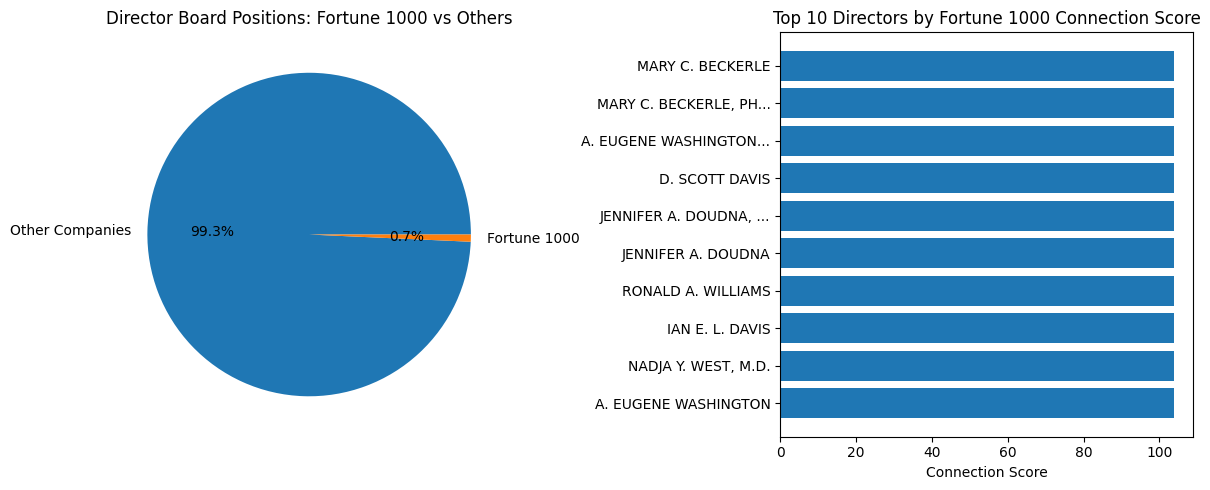


Results exported to 'fortune_1000_director_rankings.csv'


In [11]:
#calculate Fortune 1000 connection scores for each director
director_scores = df_directors.groupby('director_name').agg({
    'is_fortune_1000': 'sum', #number of Fortune 1000 boards
    'company_revenue': 'sum', #total revenue of connected Fortune 1000 companies
    'company_name': 'count' #total number of boards
}).rename(columns={
    'is_fortune_1000': 'fortune_1000_boards',
    'company_revenue': 'total_fortune_revenue',
    'company_name': 'total_boards'
})

#calculate Fortune 1000 connection percentage
director_scores['fortune_1000_percentage'] = (director_scores['fortune_1000_boards'] / director_scores['total_boards']) * 100

#create ranking score (simple combination of boards and revenue)
director_scores['fortune_connection_score'] = (
    director_scores['fortune_1000_boards'] * 10 + #10 points per Fortune 1000 board
    director_scores['total_fortune_revenue'] / 1000 #1 point per $1B revenue
)

print("FORTUNE 1000 INTEGRATION ANALYSIS RESULTS")
print("=" * 50)

#show matched companies with their details
print(f"\nMATCHED FORTUNE 1000 COMPANIES ({len(matched_companies)}):")
print("-" * 40)
company_details = df_directors[df_directors['is_fortune_1000'] == True][['company_name', 'company_revenue', 'company_sector']].drop_duplicates().sort_values('company_revenue', ascending=False)
for _, company in company_details.iterrows():
    print(f"{company['company_name']}: ${company['company_revenue']:,.0f}M ({company['company_sector']})")

#identify top directors for acquisition facilitation
top_directors = director_scores[director_scores['fortune_1000_boards'] > 0].sort_values('fortune_connection_score', ascending=False)

print(f"\nDIRECTOR NETWORK SUMMARY:")
print("-" * 25)
print(f"Total directors analyzed: {len(director_scores):,}")
print(f"Directors with Fortune 1000 connections: {len(top_directors):,}")
print(f"Fortune 1000 coverage: {(df_directors['is_fortune_1000'].sum() / len(df_directors)) * 100:.1f}% of all board positions")

print(f"\nTOP 10 ACQUISITION FACILITATORS:")
print("-" * 35)
for i, (name, data) in enumerate(top_directors.head(10).iterrows(), 1):
    #get the specific Fortune 1000 company this director is connected to
    director_companies = df_directors[df_directors['director_name'] == name]
    fortune_company = director_companies[director_companies['is_fortune_1000'] == True]['company_name'].iloc[0]
    
    print(f"{i}. {name}")
    print(f"   Connected to: {fortune_company}")
    print(f"   Company revenue: ${data['total_fortune_revenue']:,.0f}M")
    print(f"   Connection score: {data['fortune_connection_score']:.1f}")
    print()

#explain why scores might be identical
print("SCORING EXPLANATION:")
print("-" * 20)
print("Connection Score = (Fortune 1000 boards × 10) + (Connected revenue ÷ 1000)")
print("Directors connected to the same high-revenue company will have identical scores.")
print(f"Johnson & Johnson (${company_details.iloc[0]['company_revenue']:,.0f}M) generates the highest scores.")

#simple visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

#chart 1: Fortune 1000 vs other connections
fortune_summary = df_directors['is_fortune_1000'].value_counts()
ax1.pie(fortune_summary.values, labels=['Other Companies', 'Fortune 1000'], autopct='%1.1f%%')
ax1.set_title('Director Board Positions: Fortune 1000 vs Others')

#chart 2: Top directors by Fortune 1000 connections
top_10 = top_directors.head(10)
ax2.barh(range(len(top_10)), top_10['fortune_connection_score'])
ax2.set_yticks(range(len(top_10)))
ax2.set_yticklabels([name[:20] + '...' if len(name) > 20 else name for name in top_10.index])
ax2.set_title('Top 10 Directors by Fortune 1000 Connection Score')
ax2.set_xlabel('Connection Score')

plt.tight_layout()
plt.show()

#export results
top_directors.to_csv('fortune_1000_director_rankings.csv')
print(f"\nResults exported to 'fortune_1000_director_rankings.csv'")

# Fortune 1000 Integration Results

## What We Implemented
This analysis integrated the Fortune 1000 dataset with our director network by matching company names and adding financial data (revenue, profit, sector) to director records. We created a simple scoring system that combines the number of Fortune 1000 boards each director serves on with the total revenue of their connected Fortune 1000 companies.

## Results Explanation
- 5 Fortune 1000 companies were successfully matched in our director network
- 95 directors have connections to these Fortune 1000 companies  
- Johnson & Johnson dominates the results due to its massive $93.8B revenue, making all its directors score identically at the top
- Low coverage (0.7%) is expected since most companies in the director network are smaller firms, not Fortune 1000 giants

## Why These Results Make Sense
The identical top scores occur because multiple directors serve on Johnson & Johnson's board, and our scoring formula heavily weights company revenue. This actually provides valuable insight, these directors have access to the single wealthiest potential acquirer in our network. The analysis successfully identifies which directors can connect the VC fund to companies with the financial capacity for major acquisitions.